# EDA of Google Play Store Data Set

## Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from datetime import datetime, date
import scipy.stats as stats
import math
import nbimporter
from Helper_Functions import *

%matplotlib inline
sns.set(style = 'darkgrid')

## Read in the dataset

In [59]:
play_store_data = pd.read_csv('../Data/Cleaned_Play_Store_Data.csv')
# Dropping Unnamed Columns
play_store_data.drop(play_store_data.columns[
    play_store_data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

## Looking at the Category Column

### Looking at Counts of Categories

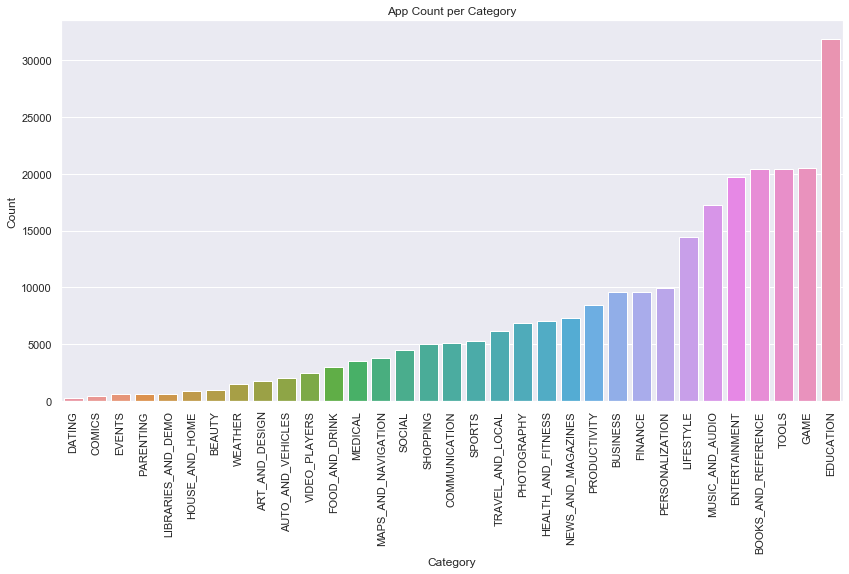

In [60]:
# Creating new dataframe using category and counts that that the category occurs
category_counts_game = pd.DataFrame(play_store_data.groupby('Category').count()['App_Name']).reset_index()
category_counts_game.rename(columns = {'App_Name': 'Count'}, inplace = True)
category_counts_game.sort_values(by = 'Count', inplace = True)

# Bar plot of Categories vs Counts
fig, ax = plt.subplots(figsize = (14,7))
category_counts_graph = sns.barplot(x = category_counts_game.Category, y = category_counts_game.Count)
category_counts_graph.set_xticklabels(category_counts_graph.get_xticklabels(),rotation=90)
plt.title('App Count per Category')

plt.savefig('../graphs/App_Count_Per_Category.png', dpi = 700);

### Looking at Installs vs Categories

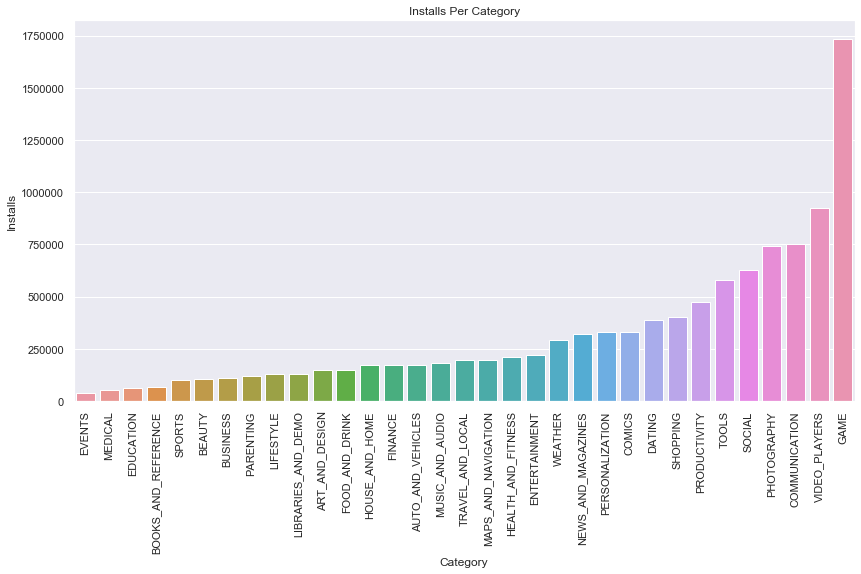

In [61]:
# Grouping Categories with their respective number of installs
category_installs = pd.DataFrame(play_store_data.groupby('Category').mean()['Installs']).reset_index()
category_installs.sort_values(by = 'Installs', inplace = True)

# Plotting Category vs Installs
fig, ax = plt.subplots(figsize = (14,7))
category_installs_graph = sns.barplot(x = category_installs.Category, y = category_installs.Installs)
category_installs_graph.set_xticklabels(category_installs_graph.get_xticklabels(),rotation=90)
plt.title('Installs Per Category')
plt.savefig('../graphs/Installs_Per_Category.png', dpi = 700);

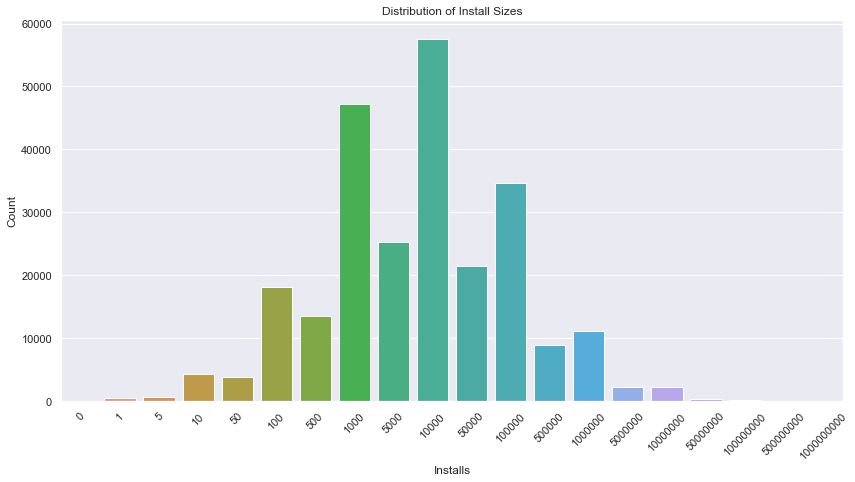

In [62]:
# Since the number of installs ranges greatly, I need to plot the distribution using bar plots
# Intilization of a DataFrame grouping by install size and counts of each install size
install_df = pd.DataFrame(play_store_data.groupby('Installs').count()['App_Name']).reset_index()
install_df.sort_values(by = 'Installs', ascending = True,inplace = True)

# Plotting Distribution of Install Sizes
fig, ax = plt.subplots(figsize = (14,7))
installs_bar = sns.barplot(install_df.Installs, install_df.App_Name)
installs_bar.set_xticklabels(installs_bar.get_xticklabels(),rotation=45)

plt.ylabel('Count')
plt.title('Distribution of Install Sizes');
plt.savefig('../graphs/Distribution_Install_Sizes.png', dpi = 700);

### Looking at Installs vs Content Rating

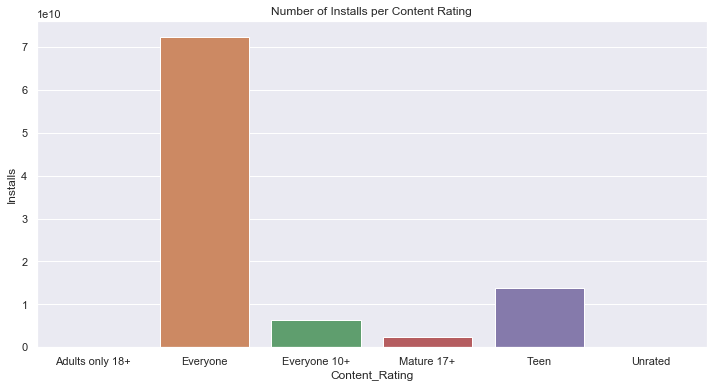

In [63]:
# Number of Installs per Content Rating
install_content_rating = pd.DataFrame(play_store_data.groupby('Content_Rating').sum()['Installs']).reset_index()
install_content_rating.sort_values(by = 'Installs', ascending = True)

#Plotting Number of Installs per Content Rating
fig, ax = plt.subplots(figsize = (12,6))
plot = sns.barplot(x = install_content_rating.Content_Rating, y = install_content_rating.Installs)


plt.title('Number of Installs per Content Rating');
plt.savefig('../graphs/Number_of_Installs_per_Content_Rating.png', dpi = 700);

### Looking at Installs vs Number of Reviews Over the Category column

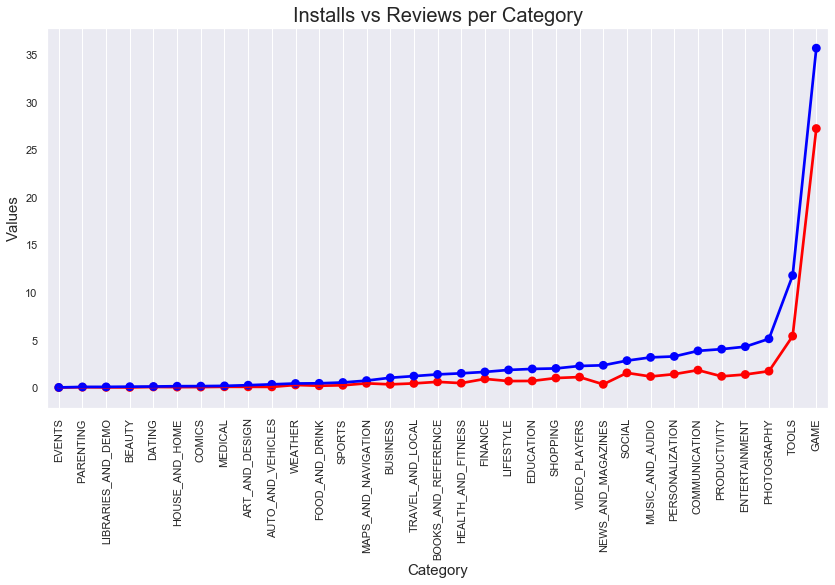

In [64]:
# Initializate of a Normalized Data Frame
# Initialize a DataFrame that contains normalized values for Installs and Reviews 
# from a normalized play_store_data DataFrame
play_store_data_game = play_store_data.copy()
normalize_col(play_store_data_game, 'Reviews')
normalize_col(play_store_data_game, 'Installs')

reviews_installs_category = pd.DataFrame(play_store_data_game.groupby(
    'Category').sum()[['Reviews', 'Installs']]).reset_index()
reviews_installs_category.sort_values(by='Installs', inplace = True)


# Plot Installs vs Reviews per Category
fig, ax = plt.subplots(figsize=(14, 7))
sns.pointplot(x=reviews_installs_category.Category,
              y=reviews_installs_category.Reviews, color='red', label='Reviews')
sns.pointplot(x=reviews_installs_category.Category, y=reviews_installs_category.Installs,
              color='blue', alpha=0.8, label='Installs')
plt.xticks(rotation=90)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.title('Installs vs Reviews per Category', fontsize=20)
plt.grid()
plt.savefig('../graphs/Installs_vs_Reviews_per_Category.png', dpi = 700);

#### Looking further into Correlation Between Installs and Reviews

In [65]:
# # Initializing correlation Data Frame from the Play_Store_Data imported
corr = play_store_data_game.corr()

# # Plot the Correlational KDE Plot
# g = sns.jointplot(corr.Installs, corr.Reviews, kind='kde')
# g = g.annotate(stats.pearsonr);

## Looking at Correlation Between Numerical Data Columns

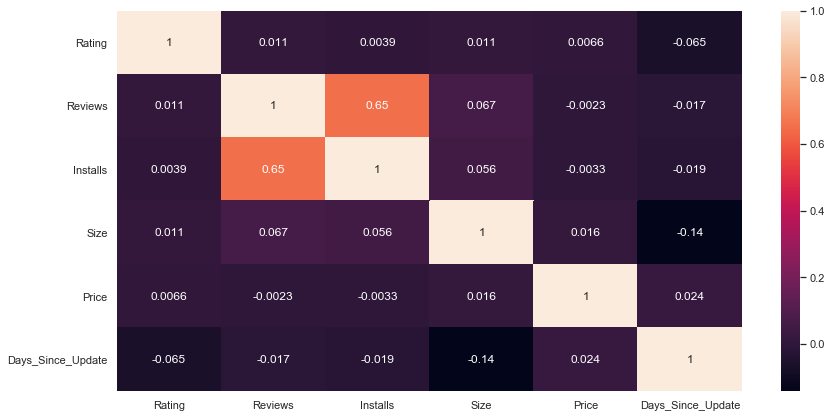

In [66]:
# Plot a Heat Map of the Correlational Data Frame
fig, ax = plt.subplots(figsize = (14,7))
g = sns.heatmap(corr, annot = True)
g = g.set_yticklabels(g.get_yticklabels(),rotation=360)

#Fix Plot Cutoff
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.savefig('../graphs/Correlation_Matrix.png', dpi = 700);

## Testing for Independence Between Installs and Reviews

In [23]:
# Using the normalized dataframe of installs and reviews based on category
reviews_installs_category.set_index('Category', inplace=True)

# Finding the Expeected Value
df = stats.chi2_contingency(reviews_installs_category)[3]

# Applying the Expected Values to create a Contingency Table
cont_table = pd.DataFrame(
    data=df[:, :],
    index=reviews_installs_category.index,
    columns=['Installs', 'Reviews']).round(2).reset_index()

# Calculating the p-value of the Chi-Squared Contingency Test
pvalue= stats.chi2_contingency(reviews_installs_category)[1]

# Calculating the degrees of freedom for the Chi-Squared Contingency Test
dof=stats.chi2_contingency(reviews_installs_category)[2]

cont_table.head()

,Category,Installs,Reviews
0,EVENTS,0.01,0.02
1,PARENTING,0.04,0.07
2,LIBRARIES_AND_DEMO,0.04,0.07
3,BEAUTY,0.04,0.08
4,DATING,0.06,0.12


In [26]:
# Printing out the results vs the null hypothesis
reviews_installs_category = pd.crosstab(play_store_data.Reviews, play_store_data.Installs)
chi, pval, dof, exp = stats.chi2_contingency(reviews_installs_category)
significance = 0.05
print('p-value=%.6f, significance=%.2f\n' % (pval, significance))
if pval < significance:
    print("""At %.2f level of significance, we reject the null hypotheses and accept H1. 
They are not independent.""" % (significance))
else:
    print("""At %.2f level of significance, we accept the null hypotheses. 
They are dependent.""" % (significance))

p-value=0.000000, significance=0.05

At 0.05 level of significance, we reject the null hypotheses and accept H1. 
They are not independent.


## Looking at the Rating Column

### Distribution of Ratings vs Number of Apps

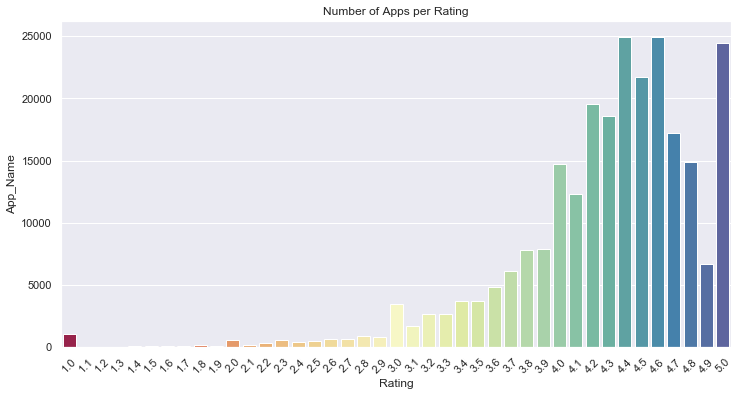

In [29]:
# Initializing a DataFrame that groups by Rating and counts the number of times it occurs
review_distribution = pd.DataFrame(play_store_data.groupby('Rating').count()['App_Name']).reset_index()
review_distribution.Rating  = review_distribution.Rating.round(1)
review_distribution = review_distribution.groupby('Rating').sum().reset_index()
review_distribution

# PLotting Rating vs Installs
fig, ax = plt.subplots(figsize = (12,6))
plot = sns.barplot(x = review_distribution.Rating, y = review_distribution.App_Name, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Number of Apps per Rating');
plt.savefig('../graphs/Number_of_Apps_per_Rating.png', dpi = 700);

### Looking at Installs vs Rating

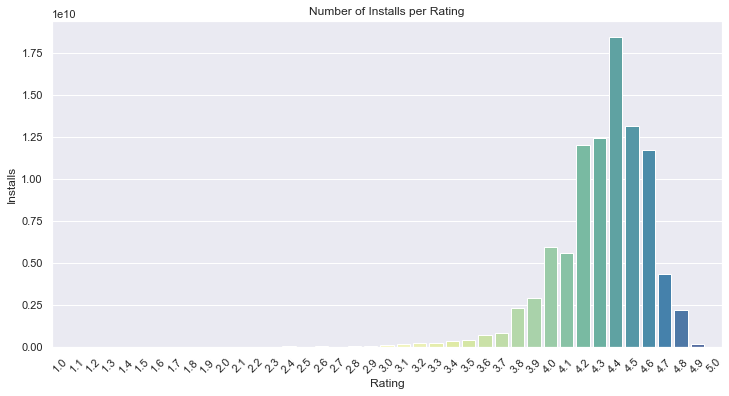

In [30]:
#installs vs ratings
install_rating = pd.DataFrame(play_store_data.groupby('Rating').sum()['Installs']).reset_index()

#limiting the rating to the one-hundredths place
install_rating.Rating = install_rating.Rating.round(1)
install_rating = install_rating.groupby('Rating').sum()['Installs'].reset_index()

# PLotting Rating vs Installs
fig, ax = plt.subplots(figsize = (12,6))
plot = sns.barplot(x = install_rating.Rating, y = install_rating.Installs, palette = 'Spectral', )
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Number of Installs per Rating');
plt.savefig('../graphs/Number_of_Installs_per_Rating.png', dpi = 700);

### Looking at Average Number of Reviews per App Rating

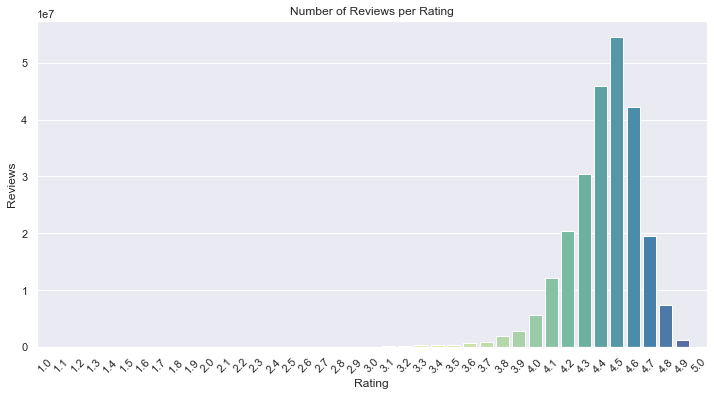

In [31]:
# Initializing a DataFram that groups by rating and averages the number of reviews based on the rating
rating_reviews = pd.DataFrame(play_store_data.groupby('Rating').sum()['Reviews']).reset_index()
rating_reviews = rating_reviews.round(1).reset_index()
rating_reviews = rating_reviews[['Rating','Reviews']]

# Finds the average number of reviews per rating
rating_reviews = pd.DataFrame(rating_reviews.groupby('Rating').mean()['Reviews']).reset_index()

# PLotting Rating vs Installs
fig, ax = plt.subplots(figsize = (12,6))
plot = sns.barplot(x = rating_reviews.Rating, y = rating_reviews.Reviews, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Number of Reviews per Rating');
plt.savefig('../graphs/Number_of_Reviews_per_Rating.png', dpi = 700);

### Looking at the Distribution of Average Rating per Category 

In [33]:
# Initializing a DataFram that groups by category and averages the number of reviews based on the category
category_avg_rating = pd.DataFrame(play_store_data.groupby('Category').mean()['Rating']).reset_index()

NameError: name 'category_avg_rating' is not defined

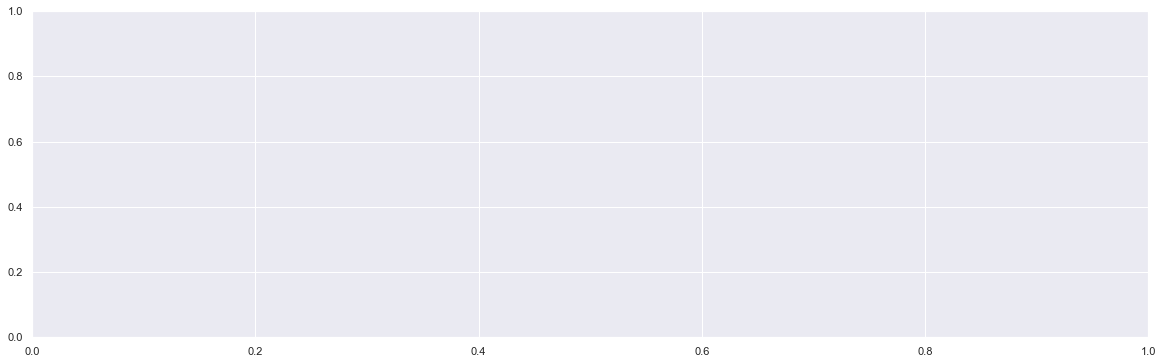

In [57]:
# PLotting Rating vs Installs
fig, ax = plt.subplots(figsize = (20,6))
plot = sns.barplot(x = category_avg_rating.Category, y = category_avg_rating.Rating, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Average Rating per Category');
plt.savefig('../graphs/Average_Rating_Per_Category.png', dpi = 700);

### Looking at Average Rating Per Number of Installs

In [50]:
d = pd.DataFrame(play_store_data.groupby('Installs').count()['Rating']).reset_index()

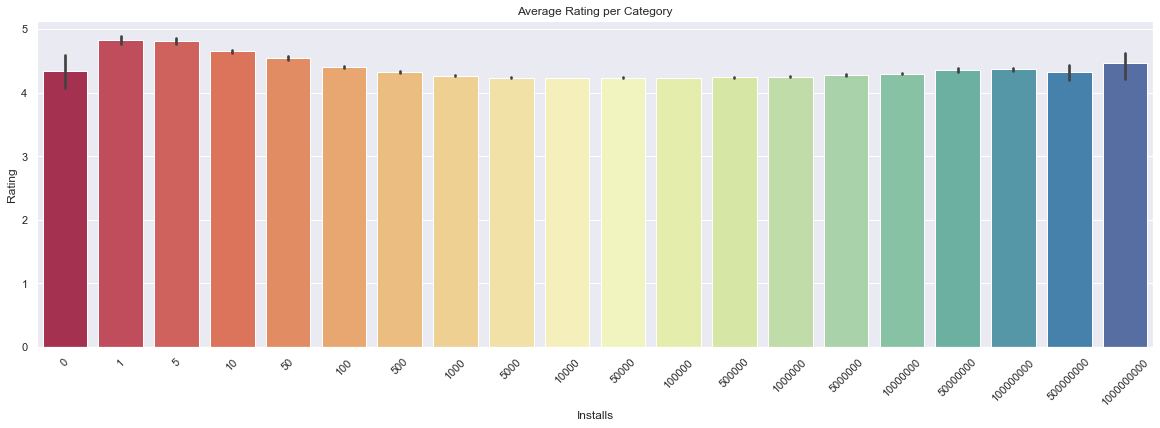

In [39]:
fig, ax = plt.subplots(figsize = (20,6))
plot = sns.barplot(x = play_store_data.Installs, y = play_store_data.Rating, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Average Rating per Category');
plt.savefig('../graphs/Average_Rating_Per_Category.png', dpi = 700);

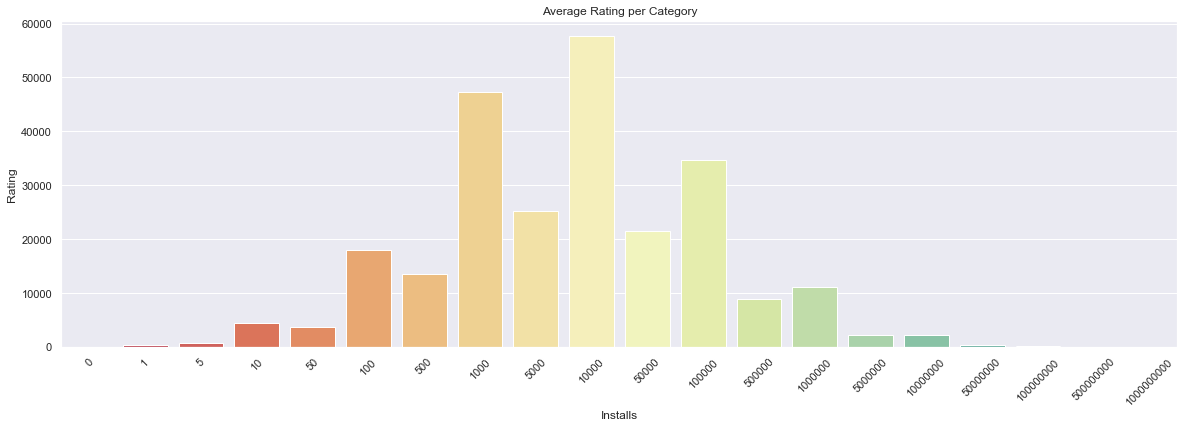

In [40]:
fig, ax = plt.subplots(figsize = (20,6))
plot = sns.barplot(x = d.Installs, y = d.Rating, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Average Rating per Category');
plt.savefig('../graphs/Average_Rating_Per_Category.png', dpi = 700);

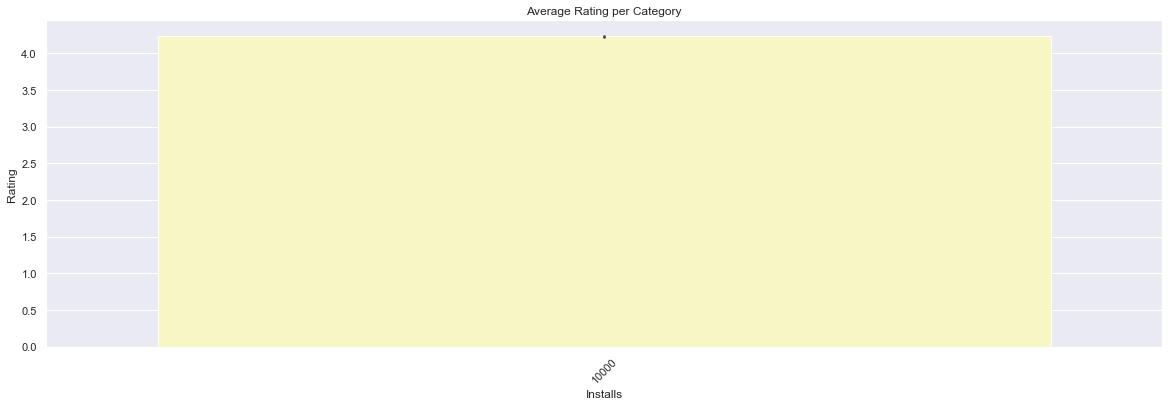

In [56]:
fig, ax = plt.subplots(figsize = (20,6))
plot = sns.barplot(x = df.Installs, y = df.Rating, palette = 'Spectral')
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

plt.title('Average Rating per Category');
plt.savefig('../graphs/Average_Rating_Per_Install_Count.png', dpi = 700);